In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load datasets
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
sample_submission = pd.read_csv('data/sample_submission.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('sample_submission shape:', sample_submission.shape)
train.head()



Train shape: (1460, 81)
Test shape: (1459, 80)
sample_submission shape: (1459, 2)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
# Show only columns in `train` that have missing values and their counts
miss_test = train.isna().sum()
miss_test = miss_test[miss_test > 0].sort_values(ascending=False)
print(f'Total columns with missing values: {len(miss_test)}')
# Display as a DataFrame for readability
miss_test.to_frame('missing_count')

Total columns with missing values: 19


,missing_count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


In [19]:
# Prepare dtypes for filling NaNs for specific columns
cols = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
        'LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual',
        'GarageCond','BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond',
        'BsmtFinType1','MasVnrArea','Electrical']

print('\nCurrent dtypes (train / test):')
for c in cols:
    t_dtype = str(train[c].dtype) if c in train.columns else 'NA'
    test_dtype = str(test[c].dtype) if c in test.columns else 'NA'
    print(f'{c}: {t_dtype} / {test_dtype}')

# Convert types: categorical -> 'category', numeric years to nullable Int64, areas/lengths to float
int_nullable = ['GarageYrBlt']
float_cols = ['LotFrontage','MasVnrArea']
cat_cols = [c for c in cols if c not in int_nullable+float_cols]

for c in cat_cols:
    if c in train.columns:
        train[c] = train[c].astype('category')
    if c in test.columns:
        test[c] = test[c].astype('category')

for c in float_cols:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors='coerce').astype('float')
    if c in test.columns:
        test[c] = pd.to_numeric(test[c], errors='coerce').astype('float')

for c in int_nullable:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors='coerce').astype('Int64')
    if c in test.columns:
        test[c] = pd.to_numeric(test[c], errors='coerce').astype('Int64')

print('\nDtypes after conversion:')
for c in cols:
    t_dtype = str(train[c].dtype) if c in train.columns else 'NA'
    test_dtype = str(test[c].dtype) if c in test.columns else 'NA'
    print(f'{c}: {t_dtype} / {test_dtype}')


Current dtypes (train / test):
PoolQC: object / object
MiscFeature: object / object
Alley: object / object
Fence: object / object
MasVnrType: object / object
FireplaceQu: object / object
LotFrontage: float64 / float64
GarageType: object / object
GarageYrBlt: float64 / float64
GarageFinish: object / object
GarageQual: object / object
GarageCond: object / object
BsmtExposure: object / object
BsmtFinType2: object / object
BsmtQual: object / object
BsmtCond: object / object
BsmtFinType1: object / object
MasVnrArea: float64 / float64
Electrical: object / object

Dtypes after conversion:
PoolQC: category / category
MiscFeature: category / category
Alley: category / category
Fence: category / category
MasVnrType: category / category
FireplaceQu: category / category
LotFrontage: float64 / float64
GarageType: category / category
GarageYrBlt: Int64 / Int64
GarageFinish: category / category
GarageQual: category / category
GarageCond: category / category
BsmtExposure: category / category
BsmtFinT

In [21]:
# Sadece eksik değerli sütunların tiplerini göster
cols = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
        'LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual',
        'GarageCond','BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond',
        'BsmtFinType1','MasVnrArea','Electrical']

print('train dtypes:')
print(train[cols].dtypes)

train dtypes:
PoolQC          category
MiscFeature     category
Alley           category
Fence           category
MasVnrType      category
FireplaceQu     category
LotFrontage      float64
GarageType      category
GarageYrBlt        Int64
GarageFinish    category
GarageQual      category
GarageCond      category
BsmtExposure    category
BsmtFinType2    category
BsmtQual        category
BsmtCond        category
BsmtFinType1    category
MasVnrArea       float64
Electrical      category
dtype: object


In [25]:
# Her eksik değerli sütun için dolu (NaN olmayan) değer sayısı
cols = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
        'LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual',
        'GarageCond','BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond',
        'BsmtFinType1','MasVnrArea','Electrical']

print('TRAIN:')
for c in cols:
    print(f'{c}:', train[c].notna().sum())
print('\nTEST:')
for c in cols:
    print(f'{c}:', test[c].notna().sum())

TRAIN:
PoolQC: 7
MiscFeature: 54
Alley: 91
Fence: 281
MasVnrType: 588
FireplaceQu: 770
LotFrontage: 1201
GarageType: 1379
GarageYrBlt: 1379
GarageFinish: 1379
GarageQual: 1379
GarageCond: 1379
BsmtExposure: 1422
BsmtFinType2: 1422
BsmtQual: 1423
BsmtCond: 1423
BsmtFinType1: 1423
MasVnrArea: 1452
Electrical: 1459

TEST:
PoolQC: 3
MiscFeature: 51
Alley: 107
Fence: 290
MasVnrType: 565
FireplaceQu: 729
LotFrontage: 1232
GarageType: 1383
GarageYrBlt: 1381
GarageFinish: 1381
GarageQual: 1381
GarageCond: 1381
BsmtExposure: 1415
BsmtFinType2: 1417
BsmtQual: 1415
BsmtCond: 1414
BsmtFinType1: 1417
MasVnrArea: 1444
Electrical: 1459


In [26]:
# Yüksek oranda eksik ve çok az dolu değeri olan sütunları sil
high_missing_cols = ['PoolQC','MiscFeature','Alley','Fence']
train.drop(columns=[c for c in high_missing_cols if c in train.columns], inplace=True)
test.drop(columns=[c for c in high_missing_cols if c in test.columns], inplace=True)
print('Dropped columns:', [c for c in high_missing_cols if c not in train.columns or c not in test.columns])
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Dropped columns: ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
Train shape: (1460, 77)
Test shape: (1459, 76)


In [28]:
# Eksik doldurma stratejisi: kategorik sentinel + sayısal median/0 + bayraklar
# Not: PoolQC, MiscFeature, Alley, Fence daha önce drop edildi.

# 1) Kategorik kolonlar (özellik yok sentinel)
cat_sent_cols = {
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtExposure': 'NoBsmt',
    'BsmtFinType2': 'NoBsmt',
    'BsmtQual': 'NoBsmt',
    'BsmtCond': 'NoBsmt',
    'BsmtFinType1': 'NoBsmt',
    'MasVnrType': 'None'
}

def add_and_fill_cat(df, mapping):
    for col, sentinel in mapping.items():
        if col in df.columns:
            if pd.api.types.is_categorical_dtype(df[col]):
                if sentinel not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories([sentinel])
            df[col] = df[col].fillna(sentinel)

add_and_fill_cat(train, cat_sent_cols)
add_and_fill_cat(test, cat_sent_cols)

# 2) Elektrik: mod ile doldur
for df in (train, test):
    if 'Electrical' in df.columns:
        mode_val = df['Electrical'].mode(dropna=True)
        if not mode_val.empty:
            fill_val = mode_val.iloc[0]
            if pd.api.types.is_categorical_dtype(df['Electrical']) and fill_val not in df['Electrical'].cat.categories:
                df['Electrical'] = df['Electrical'].cat.add_categories([fill_val])
            df['Electrical'] = df['Electrical'].fillna(fill_val)

# 3) LotFrontage: global median (Neighborhood bazlı yoksa)
if 'LotFrontage' in train.columns:
    lf_median = train['LotFrontage'].median()
    train['LotFrontage'] = train['LotFrontage'].fillna(lf_median)
if 'LotFrontage' in test.columns:
    lf_median_test = test['LotFrontage'].median() if not test['LotFrontage'].dropna().empty else lf_median
    test['LotFrontage'] = test['LotFrontage'].fillna(lf_median_test)

# 4) MasVnrArea: MasVnrType None ise 0, değilse median
if 'MasVnrArea' in train.columns and 'MasVnrType' in train.columns:
    mv_median = train['MasVnrArea'].median()
    train['MasVnrArea'] = np.where(train['MasVnrType'] == 'None', 0, train['MasVnrArea'])
    train['MasVnrArea'] = train['MasVnrArea'].fillna(mv_median)
if 'MasVnrArea' in test.columns and 'MasVnrType' in test.columns:
    mv_median_t = test['MasVnrArea'].median()
    test['MasVnrArea'] = np.where(test['MasVnrType'] == 'None', 0, test['MasVnrArea'])
    test['MasVnrArea'] = test['MasVnrArea'].fillna(mv_median_t)

# 5) GarageYrBlt: bayrak + median
for df in (train, test):
    if 'GarageYrBlt' in df.columns:
        df['HasGarage'] = df['GarageType'].ne('NoGarage').astype(int) if 'GarageType' in df.columns else 1
        med_val = df['GarageYrBlt'].median()
        df['GarageYrBlt'] = df['GarageYrBlt'].fillna(med_val)

# 6) Kalan eksikleri raporla
remaining_train = train.isna().sum().sort_values(ascending=False)
remaining_train = remaining_train[remaining_train > 0]
remaining_test = test.isna().sum().sort_values(ascending=False)
remaining_test = remaining_test[remaining_test > 0]

print('Train remaining missing cols:', remaining_train.head(20))
print('\nTest remaining missing cols:', remaining_test.head(20))

Train remaining missing cols: Series([], dtype: int64)

Test remaining missing cols: MSZoning        4
Utilities       2
BsmtFullBath    2
Functional      2
BsmtHalfBath    2
BsmtFinSF2      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Exterior2nd     1
GarageArea      1
SaleType        1
KitchenQual     1
BsmtFinSF1      1
GarageCars      1
dtype: int64


In [29]:
# Test set: fill remaining small-count missings (categorical -> mode, numeric -> median)
cat_mode_cols = ['MSZoning','Utilities','Functional','Exterior1st','Exterior2nd','SaleType','KitchenQual']
num_median_cols = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageArea','GarageCars']

# fill categoricals with mode (add category if dtype is categorical)
for col in cat_mode_cols:
    if col in test.columns:
        mode_val = test[col].mode(dropna=True)
        if not mode_val.empty:
            fill_val = mode_val.iloc[0]
            if pd.api.types.is_categorical_dtype(test[col]) and fill_val not in test[col].cat.categories:
                test[col] = test[col].cat.add_categories([fill_val])
            test[col] = test[col].fillna(fill_val)

# fill numerics with median
for col in num_median_cols:
    if col in test.columns:
        med = test[col].median()
        test[col] = test[col].fillna(med)

# report remaining missings in test
test_remaining = test.isna().sum().sort_values(ascending=False)
test_remaining = test_remaining[test_remaining > 0]
print('Test remaining missing cols after final fill:', test_remaining.head(20))

Test remaining missing cols after final fill: BsmtFinSF1    1
dtype: int64


In [30]:
# Fill the last remaining test missing (BsmtFinSF1) with median
if 'BsmtFinSF1' in test.columns:
    med = test['BsmtFinSF1'].median()
    test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(med)

# Verify no missing remains in test
test_remaining_final = test.isna().sum().sort_values(ascending=False)
test_remaining_final = test_remaining_final[test_remaining_final > 0]
print('Test remaining missing cols (final):', test_remaining_final)

Test remaining missing cols (final): Series([], dtype: int64)


Top 24 numeric features by |corr| with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.473461
Fireplaces      0.466929
GarageYrBlt     0.466754
BsmtFinSF1      0.386420
LotFrontage     0.334771
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
HasGarage       0.236832
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
Name: SalePrice, dtype: float64


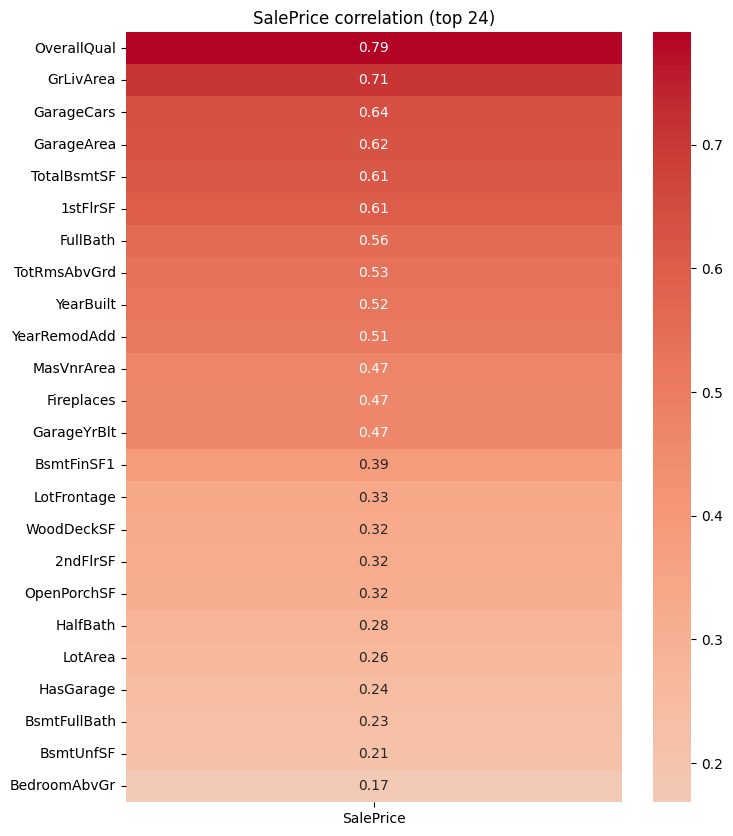

In [36]:
# Korelasyon: SalePrice ile en yüksek 24 sayısal özellik
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'SalePrice' in num_cols:
    num_cols.remove('SalePrice')
    corr = train[num_cols + ['SalePrice']].corr()['SalePrice'].drop('SalePrice').sort_values(key=lambda s: s.abs(), ascending=False)
    top20 = corr.head(24)
    print('Top 24 numeric features by |corr| with SalePrice:')
    print(top20)
    plt.figure(figsize=(8, 10))
    sns.heatmap(top20.to_frame(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('SalePrice correlation (top 24)')
    plt.show()
else:
    print('SalePrice not found in train; cannot compute correlation.')

In [38]:
# Ordinal ve kategorik encoding: mapping ve one-hot
# 1) Ordinal mapping tanımları
ordinal_maps = {
    'ExterQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
    'ExterCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
    'BsmtQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
    'BsmtCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
    'HeatingQC': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
    'KitchenQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
    'FireplaceQu': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NoFireplace':0, 'NA':0},
    'GarageQual': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NoGarage':0, 'NA':0},
    'GarageCond': {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NoGarage':0, 'NA':0},
    'PoolQC': {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0},
    'BsmtExposure': {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0},
    'BsmtFinType1': {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
    'BsmtFinType2': {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
    'GarageFinish': {'Fin':3, 'RFn':2, 'Unf':1, 'NoGarage':0, 'NA':0},
    'Fence': {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0},
    'PavedDrive': {'Y':2, 'P':1, 'N':0},
    'Functional': {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
}

# 2) Ordinal encoding uygula
for col, mapping in ordinal_maps.items():
    if col in train.columns:
        train[col + '_ord'] = train[col].map(mapping)
    if col in test.columns:
        test[col + '_ord'] = test[col].map(mapping)

# 3) Nominal kategorik sütunlar (one-hot encoding için)
nominal_cols = [
    'MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','Neighborhood',
    'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
    'Exterior1st','Exterior2nd','Foundation','Heating','CentralAir','Electrical',
    'GarageType','SaleType','SaleCondition'
]

# 4) One-hot encoding (train ve test aynı kolonlara sahip olacak şekilde)
train_nom = pd.get_dummies(train[nominal_cols], drop_first=True)
test_nom = pd.get_dummies(test[nominal_cols], drop_first=True)

# Kolonları hizala
train_nom, test_nom = train_nom.align(test_nom, join='outer', axis=1, fill_value=0)

# 5) Sonuçları birleştir (örnek)
train_encoded = pd.concat([train, train_nom], axis=1)
test_encoded = pd.concat([test, test_nom], axis=1)

print('Ordinal ve one-hot encoding tamamlandı!')
print('train_encoded shape:', train_encoded.shape)
print('test_encoded shape:', test_encoded.shape)

Ordinal ve one-hot encoding tamamlandı!
train_encoded shape: (1460, 234)
test_encoded shape: (1459, 233)


Encoding sonrası en yüksek 30 korelasyonlu feature:
OverallQual         0.790982
GrLivArea           0.708624
ExterQual_ord       0.682639
KitchenQual_ord     0.659600
BsmtQual_ord        0.644019
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
MasVnrArea          0.473461
Fireplaces          0.466929
GarageYrBlt         0.466754
HeatingQC_ord       0.427649
BsmtFinSF1          0.386420
BsmtExposure_ord    0.352958
LotFrontage         0.334771
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
BsmtFinType1_ord    0.277436
LotArea             0.263843
HasGarage           0.236832
PavedDrive_ord      0.231357
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
Name: SalePrice, dtype: float64


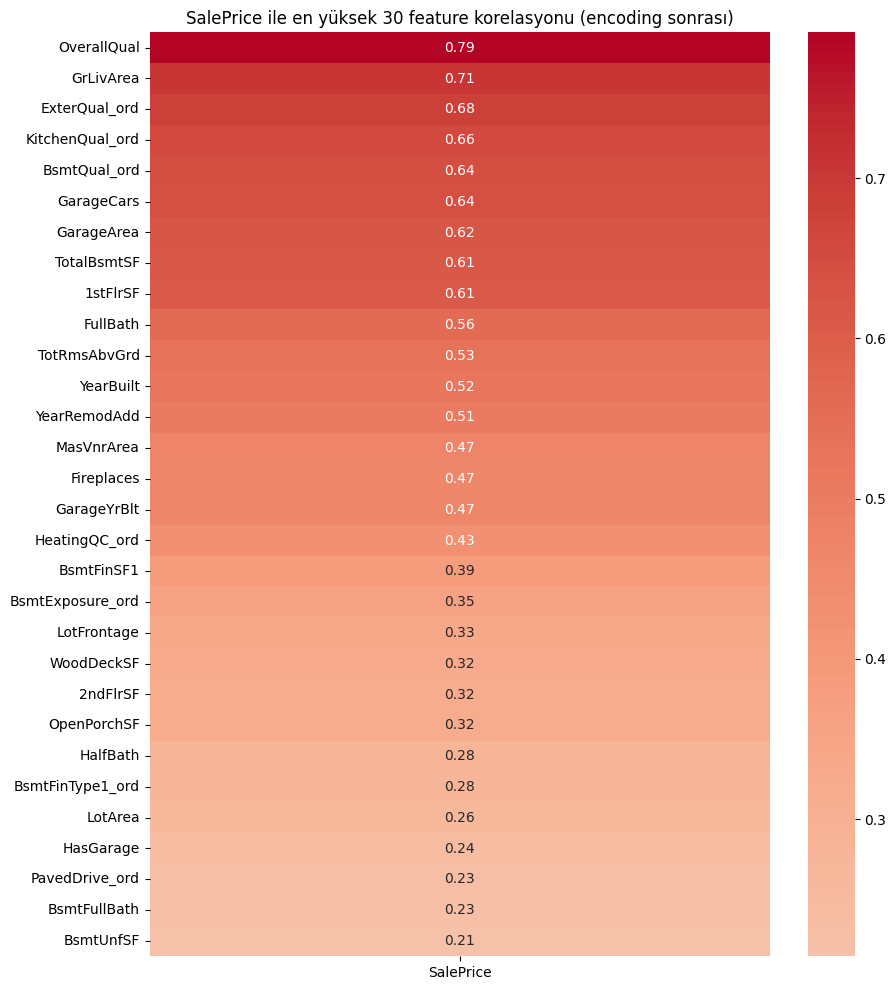

In [40]:
# Encoding sonrası korelasyon analizi ve heatmap
# Sadece sayısal sütunları kullanarak SalePrice ile en yüksek 30 korelasyonlu feature'ı göster
num_cols = train_encoded.select_dtypes(include=[np.number]).columns
corr = train_encoded[num_cols].corr()['SalePrice'].drop('SalePrice').sort_values(key=lambda s: s.abs(), ascending=False)
top_corr = corr.head(30)
print('Encoding sonrası en yüksek 30 korelasyonlu feature:')
print(top_corr)
plt.figure(figsize=(10, 12))
sns.heatmap(top_corr.to_frame(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('SalePrice ile en yüksek 30 feature korelasyonu (encoding sonrası)')
plt.show()

## XGBoost ile Model Eğitimi, Değerlendirme ve Submission
Aşağıdaki hücrelerde temel bir XGBoost modeli eğitilecek, cross-validation ile performans ölçülecek ve test seti için tahminler submission dosyasına yazılacaktır.

In [ ]:
# 1. XGBoost ile temel model eğitimi
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
import numpy as np

# Hedef ve feature'ları ayır (sadece sayısal sütunlar)
X = train_encoded.select_dtypes(include=[np.number]).drop(['SalePrice', 'Id'], axis=1, errors='ignore')
y = train_encoded['SalePrice']
X_test = test_encoded.select_dtypes(include=[np.number]).drop(['Id'], axis=1, errors='ignore')
# Test setini train ile aynı sütunlara hizala
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Modeli oluştur
xgb_model = XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)

# 2. Cross-validation ile RMSE skoru
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring=make_scorer(mean_squared_error, greater_is_better=False))
cv_rmse = np.sqrt(-cv_scores)
print('CV RMSE scores:', cv_rmse)
print('CV RMSE mean:', np.mean(cv_rmse))

# 3. Tüm veride eğit ve test setinde tahmin yap
xgb_model.fit(X, y)
y_pred_test = xgb_model.predict(X_test)

# 4. Feature importance görselleştir
import matplotlib.pyplot as plt
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(8, 8))
plt.title('XGBoost Feature Importance (Top 20)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

CV RMSE scores: [26247.20267    27609.18108166 46770.12379714 26657.07800941
 21284.29505527]
CV RMSE mean: 29713.57612269845


ValueError: feature_names mismatch: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'HasGarage', 'ExterQual_ord', 'ExterCond_ord', 'BsmtQual_ord', 'BsmtCond_ord', 'HeatingQC_ord', 'KitchenQual_ord', 'BsmtExposure_ord', 'BsmtFinType1_ord', 'BsmtFinType2_ord', 'PavedDrive_ord', 'Functional_ord'] ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'HasGarage', 'ExterQual_ord', 'ExterCond_ord', 'BsmtQual_ord', 'BsmtCond_ord', 'HeatingQC_ord', 'KitchenQual_ord', 'BsmtExposure_ord', 'BsmtFinType1_ord', 'BsmtFinType2_ord', 'PavedDrive_ord', 'Functional_ord', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_GasA', 'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Utilities_NoSeWa']
training data did not have the following fields: RoofMatl_CompShg, Condition2_RRNn, RoofMatl_Roll, Heating_GasA, Electrical_Mix, Exterior1st_ImStucc, Exterior2nd_Other, Condition2_RRAn, Exterior1st_Stone, Utilities_NoSeWa, HouseStyle_2.5Fin, Condition2_RRAe, Heating_OthW, RoofMatl_Metal, RoofMatl_Membran

In [ ]:
# 5. Submission dosyası oluştur
submission = sample_submission.copy()
submission['SalePrice'] = y_pred_test
submission.to_csv('submission_xgb.csv', index=False)
print('Submission dosyası oluşturuldu: submission_xgb.csv')
submission.head()